In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')

In [3]:
ratings=pd.read_csv('/Users/chocz/Documents/ratings_small.csv')# Contains ratings of the movies
metadata=pd.read_csv('/Users/chocz/Documents/movies_metadata.csv')# Contains information about the movies, eg:genre, busget, language etc
links=pd.read_csv('/Users/chocz/Documents/links_small.csv')# Contains IMDB and TMDB IDs of all movies
keywords=pd.read_csv('/Users/chocz/Documents/keywords.csv')# Contains information about the movie and key words defining the movie
credits=pd.read_csv('/Users/chocz/Documents/credits.csv')# Contains names of cast and crew

In [4]:
column_names = ['user_id', 'item_id']
titles = pd.read_csv('/Users/chocz/Documents/u.item.csv',sep='/t',names=column_names) 

In [5]:
titles.head()

,user_id,item_id
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...,None
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...,itle-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...,itle-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...,itle-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...,itle-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|...


In [6]:
titles=titles.user_id.apply(lambda x: pd.Series(str(x).split("|")))

In [7]:
titles.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,,http://us.imdb.com/M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,GoldenEye (1995),01-Jan-1995,,http://us.imdb.com/M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Four Rooms (1995),01-Jan-1995,,http://us.imdb.com/M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Get Shorty (1995),01-Jan-1995,,http://us.imdb.com/M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Copycat (1995),01-Jan-1995,,http://us.imdb.com/M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
titles=titles.iloc[:,[0,1]]

In [9]:
titles.head()

,0,1
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
titles[['item_id','name']]=titles.iloc[:,[0,1]]
titles=titles.iloc[:,[2,3]]

In [11]:
titles.head()

,item_id,name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
ratings['item_Id']=ratings['movieId']

In [13]:
ratings.head()

,userId,movieId,rating,timestamp,item_Id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172


In [14]:
len(ratings.movieId)

100004

In [15]:
credits.shape

(45504, 1696)

In [16]:
len(credits.id.unique())

45442

In [17]:
credits.columns

Index(['cast', 'crew', 'id', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 1686', 'Unnamed: 1687', 'Unnamed: 1688', 'Unnamed: 1689',
       'Unnamed: 1690', 'Unnamed: 1691', 'Unnamed: 1692', 'Unnamed: 1693',
       'Unnamed: 1694', 'Unnamed: 1695'],
      dtype='object', length=1696)

In [18]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45504 entries, 0 to 45503
Columns: 1696 entries, cast to Unnamed: 1695
dtypes: float64(1), object(1695)
memory usage: 588.8+ MB


In [19]:
credits.head()

,cast,crew,id,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1686,Unnamed: 1687,Unnamed: 1688,Unnamed: 1689,Unnamed: 1690,Unnamed: 1691,Unnamed: 1692,Unnamed: 1693,Unnamed: 1694,Unnamed: 1695
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
credits=credits.iloc[:,0:3]
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [21]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


cast: Information about the cast. Name of actor, gender and it's character name in movie

crew: Information about crew members. eg: Director, Editor etc

id:   It's movie ID given by TMDb


In [22]:
links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [23]:
links['item_Id']=links['movieId']
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
 3   item_Id  9125 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 285.3 KB


In [24]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


movieId: Serial number for movie

imdbId: Movie id given by IMDb

tmdbId: Movie id given by TMDb 


In [25]:
keywords.columns

Index(['id', 'keywords'], dtype='object')

In [26]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


id: It's movie ID given by TMDb

Keywords: Tags/keywords for the movie. It list of tags/keywords


In [27]:
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [28]:
metadata.iloc[0:2].transpose()

,0,1
adult,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN
budget,30000000,65000000
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
homepage,http://toystory.disney.com/toy-story,NaN
id,862,8844
imdb_id,tt0114709,tt0113497
original_language,en,en
original_title,Toy Story,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...


In [29]:
metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

adult: Indicates if the movie is X-Rated or Adult.

belongs_to_collection: A stringified dictionary that gives information on the movie series the particular film belongs to.

budget: The budget of the movie in dollars.

genres: A stringified list of dictionaries that list out all the genres associated with the movie.

homepage: The Official Homepage of the move.

id: The ID of the movie.

imdb_id: The IMDB ID of the movie.

original_language: The language in which the movie was originally shot in.

original_title: The original title of the movie.

overview: A brief blurb of the movie.

popularity: The Popularity Score assigned by TMDB.

poster_path: The URL of the poster image.

production_companies: Production companies involved with the making of the movie.

production_countries: A stringified list of countries where the movie was shot/produced in.

release_date: Theatrical Release Date of the movie.

revenue: The total revenue of the movie in dollars.

runtime: The runtime of the movie in minutes.

spoken_languages: A stringified list of spoken languages in the film.
status: The status of the movie (Released, To Be Released, Announced, etc.)

tagline: The tagline of the movie.

title: The Official Title of the movie.

video: Indicates if there is a video present of the movie with TMDB.

vote_average: The average rating of the movie.

vote_count: The number of votes by users, as counted by TMDB.


In [30]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [31]:
ratings.head()

,userId,movieId,rating,timestamp,item_Id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172


In [32]:
len(ratings.userId.unique())

671

In [33]:
ratings.head()

,userId,movieId,rating,timestamp,item_Id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172


In [34]:
ratings[['item_Id']]=ratings.item_Id.astype(str)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   item_Id    100004 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [35]:
ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [36]:
#ratings=pd.read_csv('/Users/chocz/Documents/ml-latest-small/ratings.csv')# Contains ratings of the movies
#metadata=pd.read_csv('/Users/chocz/Documents/movies_metadata.csv')# Contains information about the movies, eg:genre, busget, language etc
#links=pd.read_csv('/Users/chocz/Documents/ml-latest-small/links.csv')# Contains IMDB and TMDB IDs of all movies
#keywords=pd.read_csv('/Users/chocz/Documents/ml-latest-small/tags.csv')# Contains information about the movie and key words defining the movie
#credits=pd.read_csv('/Users/chocz/Documents/credits.csv')# Contains names of cast and crew

In [37]:
len(titles.name.unique())

1664

In [38]:
titles[titles.name.duplicated(keep=False)].sort_values(by='name')

,item_id,name
669,670,Body Snatchers (1993)
572,573,Body Snatchers (1993)
1649,"""1650","Butcher Boy, The (1998)"
1644,"""1645","Butcher Boy, The (1998)"
1233,1234,Chairman of the Board (1998)
1653,1654,Chairman of the Board (1998)
245,246,Chasing Amy (1997)
267,268,Chasing Amy (1997)
1605,1606,Deceiver (1997)
308,309,Deceiver (1997)


In [39]:
titles['item_Id']=titles['item_id']

In [40]:
df = pd.merge(ratings, titles,on='item_Id')
df=df.drop(columns=['movieId','timestamp'])
df.head()

,userId,rating,item_Id,item_id,name
0,1,2.5,31,31,Crimson Tide (1995)
1,7,3.0,31,31,Crimson Tide (1995)
2,31,4.0,31,31,Crimson Tide (1995)
3,32,4.0,31,31,Crimson Tide (1995)
4,36,3.0,31,31,Crimson Tide (1995)


In [41]:
df=df.drop(columns=['item_id'])

In [42]:
df.describe()

,userId,rating
count,31331.000000,31331.000000
mean,345.041397,3.654639
std,195.323812,1.033222
min,1.000000,0.500000
25%,177.000000,3.000000
50%,358.000000,4.000000
75%,518.000000,4.500000
max,671.000000,5.000000


In [43]:
print(df[df.name=="Body Snatchers (1993)"])

       userId  rating item_Id                   name
27719      23     4.5     670  Body Snatchers (1993)
27720     278     4.0     670  Body Snatchers (1993)
27721     564     1.0     670  Body Snatchers (1993)
31219     492     1.0     573  Body Snatchers (1993)


In [44]:
df.groupby('name')['rating'].mean()

name
'Til There Was You (1997)             4.052632
1-900 (1994)                          2.961538
101 Dalmatians (1996)                 3.173077
12 Angry Men (1957)                   4.700000
187 (1997)                            2.700000
                                        ...   
Young Guns (1988)                     4.208333
Young Guns II (1990)                  3.397059
Zeus and Roxanne (1997)               1.000000
unknown                               2.730769
¡ kˆldum klaka (Cold Fever) (1994)    3.375000
Name: rating, Length: 1002, dtype: float64

In [45]:
df.groupby('name')['rating'].count().sort_values(ascending=False).head()

name
Schindler's List (1993)      311
Stalingrad (1993)            304
Event Horizon (1997)         291
North by Northwest (1959)    274
Toy Story (1995)             247
Name: rating, dtype: int64

In [46]:
ratings_df = pd.DataFrame(df.groupby('name')['rating'].mean())
ratings_df.head()

,rating
name,
'Til There Was You (1997),4.052632
1-900 (1994),2.961538
101 Dalmatians (1996),3.173077
12 Angry Men (1957),4.700000
187 (1997),2.700000


In [47]:
ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_df.head(3)

,average_rating
name,
'Til There Was You (1997),4.052632
1-900 (1994),2.961538
101 Dalmatians (1996),3.173077


In [48]:
ratings_df['num_of_ratings'] = pd.DataFrame(df.groupby('name')['rating'].count())
ratings_df.head()

,average_rating,num_of_ratings
name,,
'Til There Was You (1997),4.052632,19
1-900 (1994),2.961538,13
101 Dalmatians (1996),3.173077,52
12 Angry Men (1957),4.700000,5
187 (1997),2.700000,10


In [49]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 'Til There Was You (1997) to ¡ kˆldum klaka (Cold Fever) (1994)
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   average_rating  1002 non-null   float64
 1   num_of_ratings  1002 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 23.5+ KB


Text(0, 0.5, 'number of films with that many ratings')

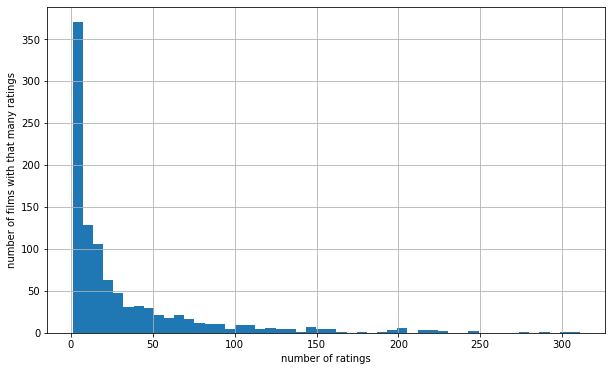

In [50]:
from matplotlib import pyplot as plt
plt.figure(figsize=[10,6]) 
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

Text(0, 0.5, 'number of films with that rating')

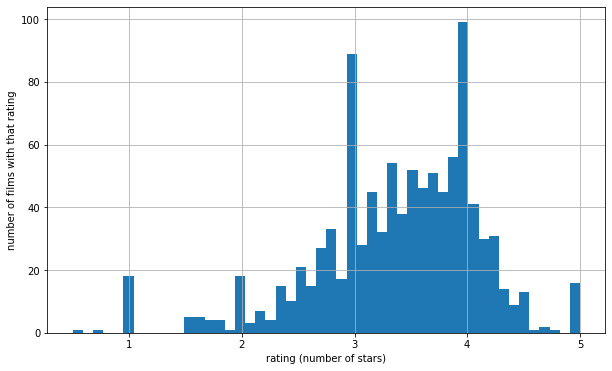

In [51]:
plt.figure(figsize=[10,6])
ratings_df.average_rating.hist(bins=50)
plt.xlabel('rating (number of stars)')
plt.ylabel('number of films with that rating')


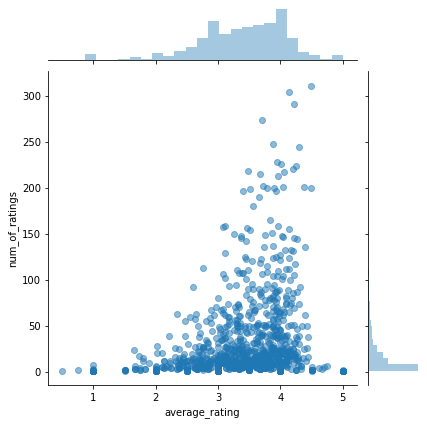

In [52]:
import seaborn as sns
sns.jointplot(x='average_rating',y='num_of_ratings', data=ratings_df, alpha=0.5)

In [53]:
ratings_df.sort_values('num_of_ratings',ascending=False).head(10)

,average_rating,num_of_ratings
name,,
Schindler's List (1993),4.487138,311
Stalingrad (1993),4.138158,304
Event Horizon (1997),4.221649,291
North by Northwest (1959),3.706204,274
Toy Story (1995),3.872470,247
Gandhi (1982),4.303279,244
Operation Dumbo Drop (1995),3.945175,228
Life with Mikey (1993),4.015487,226
Spellbound (1945),4.256696,224


Recommender System

In [54]:
metadata['genres'] = metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else [])

In [55]:
vote_counts = metadata[metadata['vote_count'].notnull()]['vote_count'].astype('int')

vote_averages = metadata[metadata['vote_average'].notnull()]['vote_average'].astype('int')

C = vote_averages.mean()
C

5.244896612406511

In [56]:
m = vote_counts.quantile(0.95)
m

434.0

In [57]:
metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [58]:
qualified = metadata[(metadata['vote_count'] >= m) & 
               (metadata['vote_count'].notnull()) & 
               (metadata['vote_average'].notnull())][['title', 
                                                'year', 
                                                'vote_count', 
                                                'vote_average', 
                                                'popularity', 
                                                'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [59]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [60]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [61]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [62]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


In [63]:
s = metadata.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = metadata.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

,0,0,0
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ..."
budget,30000000,30000000,30000000
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story
id,862,862,862
imdb_id,tt0114709,tt0114709,tt0114709
original_language,en,en,en
original_title,Toy Story,Toy Story,Toy Story
overview,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ..."
popularity,21.9469,21.9469,21.9469


In [64]:
def build_chart(genre, percentile=0.8):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: 
                        (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C),
                        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [65]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.709932
351,Forrest Gump,1994,8147,8,48.3072,7.981650
876,Vertigo,1958,1162,8,18.2082,7.876591
40251,Your Name.,2016,1030,8,34.461252,7.861619
883,Some Like It Hot,1959,835,8,11.8451,7.831401
1132,Cinema Paradiso,1988,834,8,14.177,7.831212
19901,Paperman,2012,734,8,7.19863,7.809900
37863,Sing Street,2016,669,8,10.672862,7.792904
882,The Apartment,1960,498,8,11.9943,7.729211
38718,The Handmaiden,2016,453,8,16.727405,7.705364


In [66]:
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [67]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [68]:
metadata['id'] = metadata['id'].apply(convert_int)
metadata[metadata['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [69]:
metadata = metadata.drop([19730, 29503, 35587])

In [70]:
metadata['id'] = metadata['id'].astype('int')

In [71]:
smd = metadata[metadata['id'].isin(links)]
smd.shape

(9099, 25)

In [72]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [73]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [74]:
tfidf_matrix.shape

(9099, 268124)

In [75]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [76]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [77]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [78]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [79]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

Content based Recommender System using Metadata

In [80]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
credits['id'] = credits['id']
metadata['id'] = metadata['id'].astype('int')

In [81]:
metadata.shape

(45463, 25)

In [82]:
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [83]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45504 entries, 0 to 45503
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cast    45503 non-null  object 
 1   crew    45493 non-null  object 
 2   id      45448 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


In [84]:
smd = metadata[metadata['id'].isin(links)]
smd.shape

(9199, 28)

In [85]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [86]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [87]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [88]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [89]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    325
based on novel          318
Name: keyword, dtype: int64

In [90]:
s = s[s > 1]

In [91]:
stemmer = SnowballStemmer('english')

In [92]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [93]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [94]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [95]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [96]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [97]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [98]:
get_recommendations('The Dark Knight').head(10)

6208                 Batman Begins
6613                  The Prestige
2083                     Following
7635                     Inception
4141                      Insomnia
3378                       Memento
8595                  Interstellar
7646    Batman: Under the Red Hood
1132                Batman Returns
8908       Kidnapping Mr. Heineken
Name: title, dtype: object

In [99]:
get_recommendations('Inception').head(10)

6613                             The Prestige
3378                                  Memento
4141                                 Insomnia
2083                                Following
8595                             Interstellar
6971                          The Dark Knight
6208                            Batman Begins
5630    Sky Captain and the World of Tomorrow
8483                                  Don Jon
4169                          Minority Report
Name: title, dtype: object

In [100]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [101]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7635,Inception,14075,8,2010,7.917588
8595,Interstellar,11187,8,2014,7.897107
6613,The Prestige,4510,8,2006,7.758148
3378,Memento,4168,8,2000,7.740175
6208,Batman Begins,7511,7,2005,6.904127
1132,Batman Returns,1706,6,1992,5.846862
4141,Insomnia,1181,6,2002,5.797081
132,Batman Forever,1529,5,1995,5.054144
9005,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1258,Batman & Robin,1447,4,1997,4.287233


In [102]:
reader = Reader()

In [103]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [104]:
from surprise.model_selection import cross_validate
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.89104082, 0.90229758, 0.90071283, 0.89103413, 0.90176585]),
 'test_mae': array([0.68599238, 0.69594322, 0.69462957, 0.68675756, 0.69369539]),
 'fit_time': (3.861142158508301,
  4.310672998428345,
  3.5130560398101807,
  3.7224509716033936,
  3.547400951385498),
 'test_time': (0.11822700500488281,
  0.10736680030822754,
  0.2175297737121582,
  0.09295415878295898,
  0.09688687324523926)}

In [105]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=.25)
svd.fit(trainset)
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9011


0.9011171503355934

In [106]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp,item_Id
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172
5,1,1263,2.0,1260759151,1263
6,1,1287,2.0,1260759187,1287
7,1,1293,2.0,1260759148,1293
8,1,1339,3.5,1260759125,1339
9,1,1343,2.0,1260759131,1343


In [107]:
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.754026306408658, details={'was_impossible': False})

In [108]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [109]:
id_map = pd.read_csv('/Users/chocz/Documents/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [110]:
indices_map = id_map.set_index('id')

In [119]:
def hybrid(title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'id']]
    return movies.head(10)

In [121]:
hybrid('The Dark Knight')

,title,vote_count,vote_average,release_date,id
6208,Batman Begins,7511.0,7.5,2005-06-10,272
6613,The Prestige,4510.0,8.0,2006-10-19,1124
2083,Following,363.0,7.2,1998-09-12,11660
7635,Inception,14075.0,8.1,2010-07-14,27205
4141,Insomnia,1181.0,6.8,2002-05-24,320
3378,Memento,4168.0,8.1,2000-10-11,77
8595,Interstellar,11187.0,8.1,2014-11-05,157336
7646,Batman: Under the Red Hood,459.0,7.6,2010-07-27,40662
1132,Batman Returns,1706.0,6.6,1992-06-19,364
8908,Kidnapping Mr. Heineken,193.0,5.8,2015-03-12,228968
